In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('../data/processed/train_FD001_clean.csv')
df.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [21]:
max_cycles = df.groupby('unit_number')['time_cycles'].transform('max')
df['RUL'] = max_cycles - df['time_cycles']
df[['unit_number', 'RUL', 'time_cycles']]

,unit_number,RUL,time_cycles
0,1,191,1
1,1,190,2
2,1,189,3
3,1,188,4
4,1,187,5
...,...,...,...
20626,100,4,196
20627,100,3,197
20628,100,2,198
20629,100,1,199


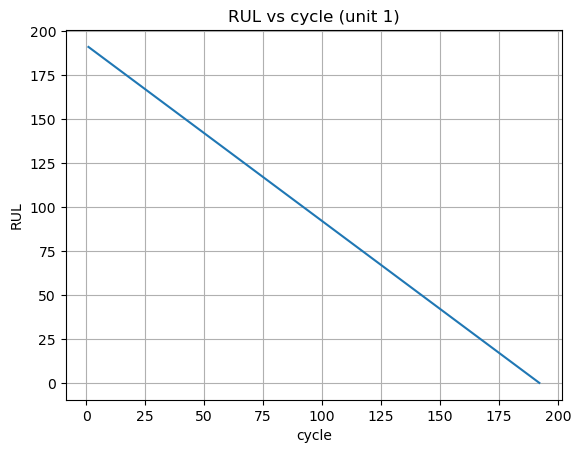

In [23]:
u1 = df[df['unit_number']==1]

plt.plot(u1['time_cycles'], u1['RUL'])
plt.title('RUL vs cycle (unit 1)')
plt.xlabel('cycle')
plt.ylabel('RUL')
plt.grid()
plt.show()

In [26]:
threshold = 1e-5
low_var = df.var()[df.var() < threshold].index
low_var


Index(['setting_1', 'setting_2', 'setting_3', 'sensor_1', 'sensor_5',
       'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19'],
      dtype='object')